In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import sys
sys.path.insert(0, "/Users/jin/Programming/Machine_Learning/All-about-Market/trading/Jeong/machine_trade/code")
import transform_feature
from DataBaseControl import DataBaseControl
import model
from functools import reduce

In [2]:

db_control = DataBaseControl("raw","BTCUSD", "1d")
bit =  db_control.get_df("*")
bit = bit.loc[~bit.index.duplicated()]
bit.dropna(inplace=True)
bit.drop_duplicates(inplace=True)
transformer = transform_feature.FeatureTransformer(adj_close=bit['Adj Close'], high=bit['High'], low=bit['Low'], volume=bit['Volume'])
transformer.transform(bit, is_coin = True)
bit

Create new feature complete


,Open,High,Low,Close,Adj Close,Volume,Rsi,Moment,Pct_change,OBV,William
Date,,,,,,,,,,,
2015-02-10,220.281998,221.807007,215.332001,219.839005,219.839005,21115100,42.597041,0.827181,-3.142676,-155617504,-67.587762
2015-02-11,219.731995,223.406006,218.074005,219.184998,219.184998,17201900,42.330900,0.823603,-7.993992,-172819404,-78.517210
2015-02-12,219.207993,222.199005,217.613998,221.764008,221.764008,15206200,43.821488,0.828948,-2.421809,-157613204,-76.272211
2015-02-13,221.968994,240.259003,221.261993,235.427002,235.427002,42744400,51.041239,0.859644,3.779542,-114868804,-64.378730
2015-02-14,235.528000,259.808014,235.528000,257.321014,257.321014,49732500,59.928230,0.908610,18.520491,-65136304,-49.949619
...,...,...,...,...,...,...,...,...,...,...,...
2022-05-04,37748.011719,39902.949219,37732.058594,39698.371094,39698.371094,36754404490,48.365955,61.845985,-1.878322,1876222660908,-65.365841
2022-05-05,39695.746094,39789.281250,35856.515625,36575.140625,36575.140625,43106256317,38.143361,61.370995,-4.046230,1833116404591,-90.443643
2022-05-06,36573.183594,36624.359375,35482.132812,36040.921875,36040.921875,37795577489,36.713965,60.948847,-8.155219,1795320827102,-92.921565


In [3]:
vix = db_control.get_df("Date","Close", table_name="VIX_1d")
usd = db_control.get_df("Date","Close", table_name="DXF_1d")
tnx = db_control.get_df("Date","Close", table_name="TNX_1d")
gld = db_control.get_df("Date","Close", table_name="GCF_1d")
qqq = db_control.get_df("Date","Close", table_name="QQQ_1d")
data_frames = [bit, vix, usd, tnx, qqq, gld]
for df, ticker in zip(data_frames[1:], ["VIX","USD","TNX" ,"QQQ", "GOLD"]):
    df.columns = [f"{ticker}_{c}" for c in df.columns]


In [4]:
df = reduce(lambda left, right: left.join(right), data_frames)
df

,Open,High,Low,Close,Adj Close,Volume,Rsi,Moment,Pct_change,OBV,William,VIX_Close,USD_Close,TNX_Close,QQQ_Close,GOLD_Close
Date,,,,,,,,,,,,,,,,
2015-02-10,220.281998,221.807007,215.332001,219.839005,219.839005,21115100,42.597041,0.827181,-3.142676,-155617504,-67.587762,NaN,NaN,NaN,104.400002,NaN
2015-02-11,219.731995,223.406006,218.074005,219.184998,219.184998,17201900,42.330900,0.823603,-7.993992,-172819404,-78.517210,NaN,NaN,NaN,104.779999,NaN
2015-02-12,219.207993,222.199005,217.613998,221.764008,221.764008,15206200,43.821488,0.828948,-2.421809,-157613204,-76.272211,NaN,NaN,NaN,106.000000,NaN
2015-02-13,221.968994,240.259003,221.261993,235.427002,235.427002,42744400,51.041239,0.859644,3.779542,-114868804,-64.378730,NaN,NaN,NaN,106.910004,NaN
2015-02-14,235.528000,259.808014,235.528000,257.321014,257.321014,49732500,59.928230,0.908610,18.520491,-65136304,-49.949619,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-04,37748.011719,39902.949219,37732.058594,39698.371094,39698.371094,36754404490,48.365955,61.845985,-1.878322,1876222660908,-65.365841,25.420000,102.594002,2.917,329.600006,1867.000000
2022-05-05,39695.746094,39789.281250,35856.515625,36575.140625,36575.140625,43106256317,38.143361,61.370995,-4.046230,1833116404591,-90.443643,31.200001,103.802002,3.066,313.000000,1874.000000
2022-05-06,36573.183594,36624.359375,35482.132812,36040.921875,36040.921875,37795577489,36.713965,60.948847,-8.155219,1795320827102,-92.921565,30.190001,103.680000,3.123,309.250000,1881.199951


In [5]:
new_df = df.loc[~df.index.duplicated()]
new_df = new_df.ffill()
new_df['Target'] = np.sign(new_df['Adj Close'].diff()).shift(-1)
new_df.dropna(inplace=True)
new_df

,Open,High,Low,Close,Adj Close,Volume,Rsi,Moment,Pct_change,OBV,William,VIX_Close,USD_Close,TNX_Close,QQQ_Close,GOLD_Close,Target
Date,,,,,,,,,,,,,,,,,
2015-02-27,236.436005,256.653015,236.436005,253.828003,253.828003,44013900,58.602115,0.924069,7.405871,-91677804,-21.984833,13.340000,95.320999,2.002,108.400002,1212.599976,1.0
2015-02-28,253.520004,254.692001,249.479004,254.263000,254.263000,13949300,58.802083,0.921736,5.818138,-77728504,-22.300819,13.340000,95.320999,2.002,108.400002,1212.599976,1.0
2015-03-01,254.283005,261.660004,245.932999,260.201996,260.201996,25213700,61.534015,0.934267,6.736835,-52514804,-10.629639,13.340000,95.320999,2.002,108.400002,1212.599976,1.0
2015-03-02,260.356995,276.300995,258.312988,275.670013,275.670013,40465700,67.566482,0.968223,12.732797,-12049104,-1.024720,13.040000,95.478996,2.084,109.379997,1207.699951,1.0
2015-03-03,275.045990,285.795990,268.161011,281.701996,281.701996,50461300,69.570593,0.980679,19.376884,38412196,-5.760430,13.860000,95.407997,2.122,108.870003,1204.000000,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-03,38528.109375,38629.996094,37585.621094,37750.453125,37750.453125,27326943244,38.879318,61.988710,-4.354879,1839468256418,-97.928917,29.250000,103.496002,2.960,318.820007,1868.800049,1.0
2022-05-04,37748.011719,39902.949219,37732.058594,39698.371094,39698.371094,36754404490,48.365955,61.845985,-1.878322,1876222660908,-65.365841,25.420000,102.594002,2.917,329.600006,1867.000000,-1.0
2022-05-05,39695.746094,39789.281250,35856.515625,36575.140625,36575.140625,43106256317,38.143361,61.370995,-4.046230,1833116404591,-90.443643,31.200001,103.802002,3.066,313.000000,1874.000000,-1.0


In [7]:
SIZE = 120
X = new_df.drop(['Target'],axis=1)
pred = []
feature_res = pd.DataFrame(columns= X.columns)
f1_res = pd.DataFrame()
total_pred = []
for i in range(len(new_df) - SIZE - 1):
    train_X = X.iloc[i: i + SIZE]
    train_y = new_df['Target'].iloc[i: i + SIZE]

    test_X = X.iloc[i + SIZE]
    test_y = new_df['Target'].iloc[i + SIZE]

    rf_model = RandomForestClassifier(n_jobs=-1)
    rf_model.fit(train_X, train_y)

    pred.append(*rf_model.predict([test_X]))
    total_pred.append(pred)

    if len(pred) == SIZE:
        target = new_df['Target'].iloc[i : i + SIZE]
        feature_imp = pd.DataFrame(data=rf_model.feature_importances_).T
        feature_imp.columns=train_X.columns
        feature_res = pd.concat([feature_res, feature_imp])

        cls_report = classification_report(target, pred, output_dict=True, target_names=["up", "down"], labels=[1,-1])
        up_report = pd.DataFrame([cls_report["up"]])
        down_report = pd.DataFrame([cls_report["down"]])

        up_report.columns = ["up_" + c for c in up_report]
        down_report.columns = ["down_" + c for c in down_report]

        cls_report = pd.concat([up_report, down_report], axis=1)
        f1_res = f1_res.append(cls_report)
        
        
        pred = []
        


In [8]:
f1_res.describe()

,up_precision,up_recall,up_f1-score,up_support,down_precision,down_recall,down_f1-score,down_support
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.643898,0.630391,0.634029,65.650000,0.565267,0.577639,0.567713,54.300000
std,0.074049,0.081884,0.064943,7.499298,0.076312,0.083539,0.065304,7.595705
min,0.516129,0.507692,0.537815,56.000000,0.450980,0.435484,0.481928,40.000000
25%,0.595373,0.558149,0.586919,60.000000,0.497340,0.515980,0.503788,50.500000
50%,0.662738,0.638169,0.639344,64.000000,0.579430,0.571397,0.553719,56.000000
75%,0.696968,0.682250,0.682501,69.500000,0.605865,0.649904,0.629430,60.000000
max,0.739130,0.823529,0.777778,79.000000,0.727273,0.719298,0.666667,64.000000


In [9]:
feature_res.describe()

,Open,High,Low,Close,Adj Close,Volume,Rsi,Moment,Pct_change,OBV,William,VIX_Close,USD_Close,TNX_Close,QQQ_Close,GOLD_Close
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.063441,0.059711,0.058270,0.059749,0.059198,0.077496,0.065064,0.062630,0.067595,0.083921,0.068828,0.053901,0.059629,0.053208,0.053745,0.053615
std,0.009163,0.007791,0.008617,0.012112,0.011134,0.012616,0.009526,0.010569,0.012888,0.019871,0.014186,0.009445,0.015236,0.010161,0.010116,0.017301
min,0.044056,0.044113,0.046050,0.040263,0.040006,0.059596,0.047601,0.047837,0.042654,0.053204,0.049912,0.041846,0.032168,0.029248,0.039460,0.038692
25%,0.057354,0.054072,0.051321,0.053250,0.053410,0.069438,0.059631,0.057719,0.061993,0.068266,0.055936,0.047991,0.049873,0.048396,0.045332,0.045488
50%,0.062604,0.060517,0.056665,0.058832,0.056107,0.075162,0.063386,0.060149,0.065903,0.085574,0.068595,0.051378,0.058948,0.054446,0.051945,0.049775
75%,0.070237,0.065208,0.064235,0.065032,0.063862,0.085033,0.070758,0.065096,0.072697,0.101104,0.078092,0.057472,0.064488,0.060319,0.060789,0.054956
max,0.081853,0.072854,0.073539,0.087276,0.087813,0.100900,0.081657,0.096732,0.105164,0.115958,0.103783,0.075637,0.108127,0.068326,0.072410,0.118763


Text(0.5, 1.0, 'Random Forest: Feature Importance Graph')

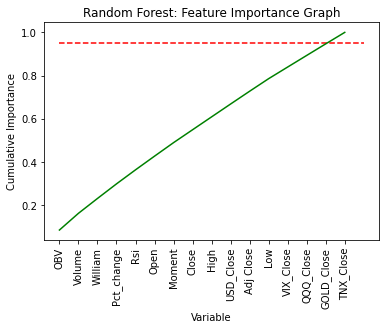

In [16]:


# Cumulative importances
cumulative_importances = feature_res.mean().sort_values(ascending=False).cumsum()

# Make a line graph

plt.plot(cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin = 0, xmax = len(cumulative_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable')
plt.ylabel('Cumulative Importance')
plt.title('Random Forest: Feature Importance Graph')

In [34]:
date_index = new_df.index[SIZE: len(total_pred) + SIZE]
pred_series = pd.Series(index=date_index, data=total_pred)
target = new_df['Target'].loc[date_index]

Date
2015-06-27   -1.0
2015-06-28    1.0
2015-06-29    1.0
2015-06-30   -1.0
2015-07-01   -1.0
             ... 
2022-01-16   -1.0
2022-01-17    1.0
2022-01-18   -1.0
2022-01-19   -1.0
2022-01-20   -1.0
Name: Target, Length: 2400, dtype: float64

In [35]:
pred_series.to_csv("pred.csv")

In [36]:
def get_trade_point(pred): 
    """ 예측 데이터와 실제 가격의 증감률의 차이에 따라 투자 조건을 다르게 했을 때의
        달라지는 수익률 곡선을 구해준다.
    """
    long_point = [] 
    short_point = [] 
    before = 1
    for date, value in pred.items():
        # if value * before < 0:
        if value > 0:
            long_point.append(date)
        else:
            short_point.append(date)
        # before = value
    
    return long_point, short_point

def get_profit(in_point, is_short=False):
    out_point = [new_df.index.get_loc(p) + 1 for p in in_point]
    if out_point[-1] >= len(new_df):
        out_point = out_point[:-1]
        in_point = in_point[:-1]
    if is_short:
        profit = (new_df['Adj Close'].loc[in_point].values - new_df['Adj Close'].iloc[out_point].values).cumsum()
    else:
        profit = (new_df['Adj Close'].iloc[out_point].values - new_df['Adj Close'].loc[in_point].values).cumsum()
    return profit

long_point, short_point = get_trade_point(pred_series)
target_long_point, target_short_point = get_trade_point(target)



In [40]:
def plot_point(long_point, short_point):
    out_value = new_df['Adj Close'].loc[short_point]
    buy_value = new_df['Adj Close'].loc[long_point]
    plt.figure(figsize=(16,10))
    plt.plot(df['Adj Close'])
    plt.scatter(x=short_point, y = out_value, c='r')
    plt.scatter(x=long_point, y = buy_value, c='b')
    plt.xlim(new_df.index[-300], new_df.index[-SIZE])


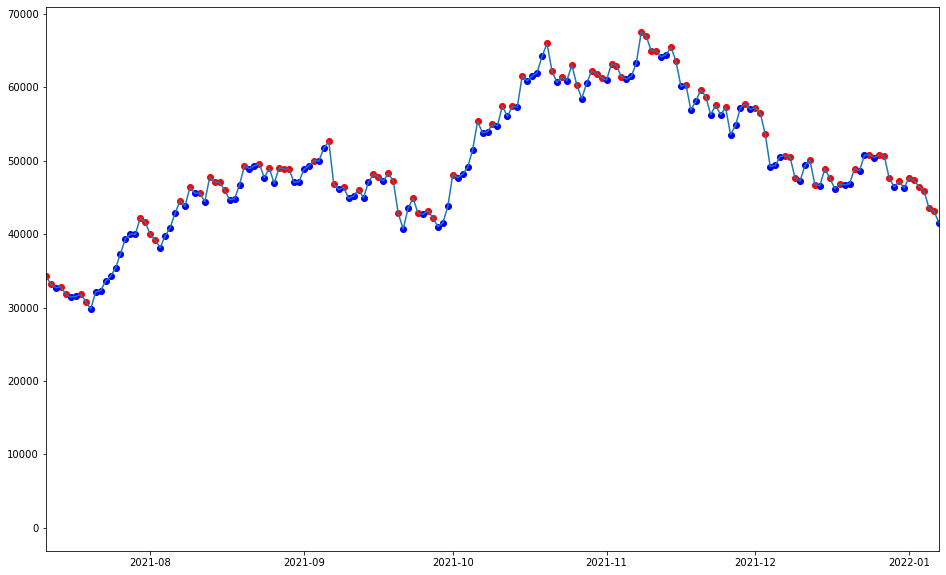

In [41]:
plot_point(target_long_point, target_short_point)

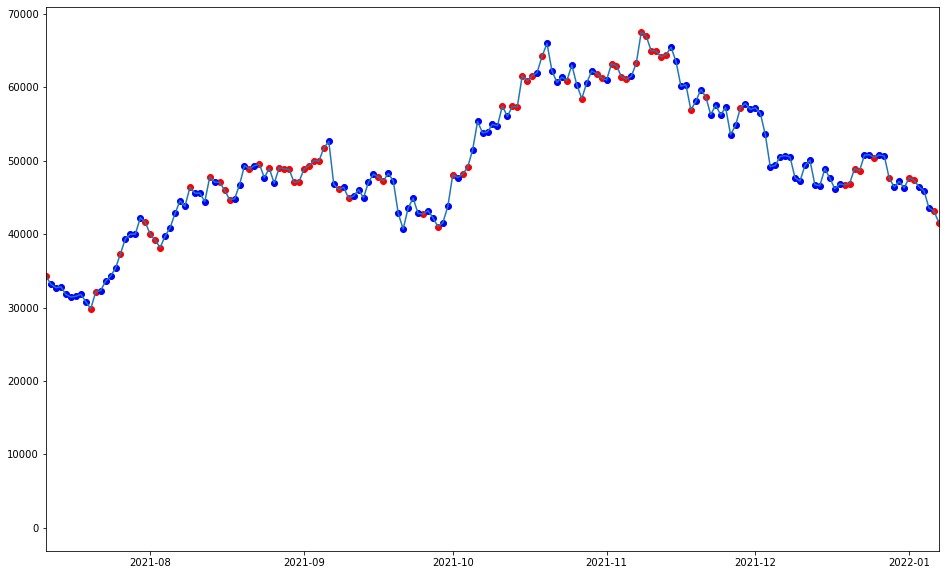

In [42]:
plot_point(long_point, short_point)

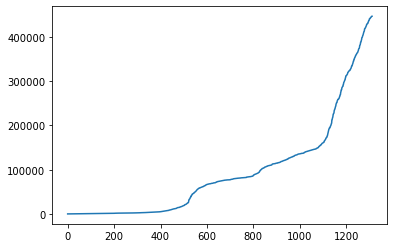

In [43]:
plt.plot(get_profit(target_long_point))

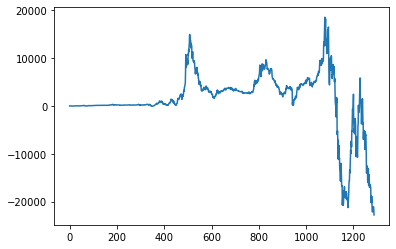

In [44]:
plt.plot(get_profit(long_point))

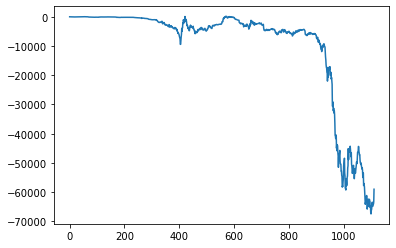

In [45]:
plt.plot(get_profit(short_point, is_short=True))

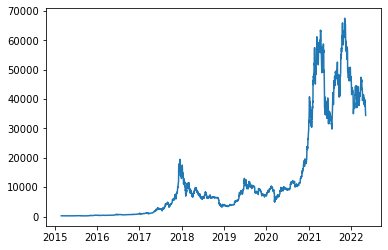

In [ ]:
plt.plot(new_df['Adj Close'])